## Classification

The image classification task is the simplest, the neural network receives an image at the input and at the output it will give a probability distribution over all the classes that we consider

## Classification Example

Import libraries and download the dataset

In [ ]:
import torch
import torchvision

dataset = {
    'train': torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
    'test': torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
}

len(dataset['train']), len(dataset['test'])

(60000, 10000)

Visualization of examples of images in the dataset to get an idea of the type of data with which we work

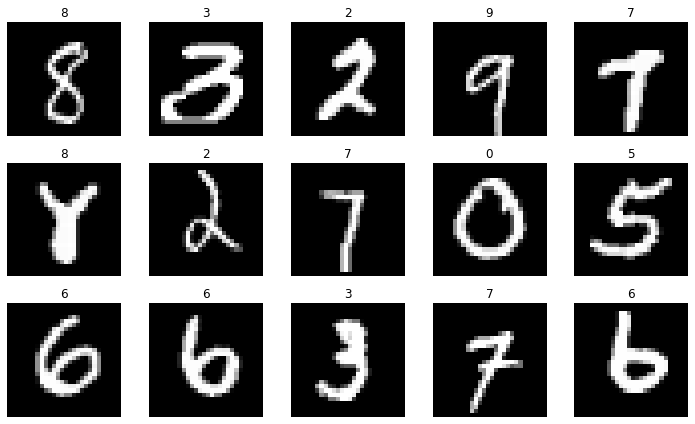

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(label)
plt.tight_layout()
plt.show()

In [ ]:
img.shape, img.dtype, img.max(), img.min()

(torch.Size([1, 28, 28]), torch.float32, tensor(1.), tensor(0.))

## Model

In [ ]:
 def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class CNN(torch.nn.Module):
    def __init__(self, n_channels=1, n_outputs=10):
        super().__init__()
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.fc = torch.nn.Linear(128*7*7, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
model = CNN()
output = model(torch.randn(64, 1, 28, 28))
output.shape

torch.Size([64, 10])

## Define Dataloader

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 1, 28, 28])

## Fit function for training

In [ ]:
from tqdm import tqdm
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN()
fit(model, dataloader)

val_loss 0.04866 val_acc 0.98348: 100%|██████████| 157/157 [00:12<00:00, 12.15it/s]


Epoch 1/5 loss 0.14260 val_loss 0.04866 acc 0.95697 val_acc 0.98348


val_loss 0.03140 val_acc 0.98885: 100%|██████████| 157/157 [00:13<00:00, 12.06it/s]


Epoch 2/5 loss 0.04498 val_loss 0.03140 acc 0.98614 val_acc 0.98885


val_loss 0.03317 val_acc 0.98836: 100%|██████████| 157/157 [00:13<00:00, 11.92it/s]


Epoch 3/5 loss 0.03206 val_loss 0.03317 acc 0.98991 val_acc 0.98836


val_loss 0.02793 val_acc 0.99045: 100%|██████████| 157/157 [00:14<00:00, 11.12it/s]


Epoch 4/5 loss 0.02390 val_loss 0.02793 acc 0.99285 val_acc 0.99045


val_loss 0.03505 val_acc 0.98915: 100%|██████████| 157/157 [00:13<00:00, 12.05it/s]

Epoch 5/5 loss 0.01898 val_loss 0.03505 acc 0.99390 val_acc 0.98915


## Evaluation

Once our model has been trained we can use it to generate predictions on the test data

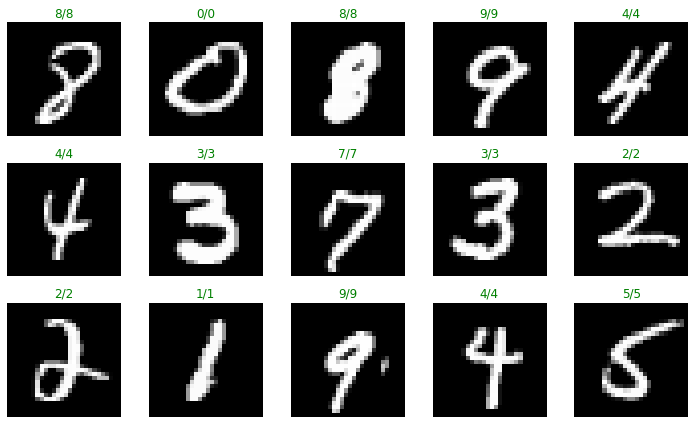

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['test'])-1)
        img, label = dataset['test'][ix]
        preds = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(preds, axis=1)[0].item()
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(f'{label}/{pred}', color="red" if label != pred else "green")
plt.tight_layout()
plt.show()